In [ ]:
import os
import json
import math
import numpy as np 
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Przygotowanie danych

In [ ]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root="data/", train=True, transform=transform, download=True)

# Loading the test set
test_set = FashionMNIST(root="data/", train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([test_set[i][0] for i in range(10,10+num)], dim=0)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Budowanie autoenkodera wariacyjnego 
VAE tak samo jak zwykły autoenkoder zbudowany jest z enkodera który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z**, oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**

Zacznijmy od stworzenia enkodera

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat
        

### Uzupełnij metodę losowania nowych przykładów w przestrzeni ukrytej

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        z = mean + var * torch.rand_like(var)
        # z = mean # Change to proper sampling
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [ ]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)

# Możemy zacząć trening

In [ ]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()             
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 loss 8631.058243189103, test L1 = 0.09181179143488408
Epoch 1 loss 4402.46712865585, test L1 = 0.07931052558124066
Epoch 2 loss 3679.4670848357373, test L1 = 0.07307190783321857
Epoch 3 loss 3321.70353503105, test L1 = 0.06930692624300719
Epoch 4 loss 3037.6359289446445, test L1 = 0.06591087989509106
Epoch 5 loss 2836.6827173477564, test L1 = 0.063393968436867
Epoch 6 loss 2668.4048435830664, test L1 = 0.06137523576617241
Epoch 7 loss 2536.543762728699, test L1 = 0.059721471183001994
Epoch 8 loss 2427.946034488515, test L1 = 0.05837432285770774
Epoch 9 loss 2343.4300130208335, test L1 = 0.057132570538669825
Epoch 10 loss 2264.697455512153, test L1 = 0.05652021989226341
Epoch 11 loss 2202.0848106971152, test L1 = 0.055228762701153754
Epoch 12 loss 2140.4893642327725, test L1 = 0.05447817454114556
Epoch 13 loss 2092.13570045406, test L1 = 0.053690485469996926
Epoch 14 loss 2043.16795831664, test L1 = 0.053080642409622666
Epoch 15 loss 2003.69531510834, test L1 = 0.052571200951933

In [ ]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

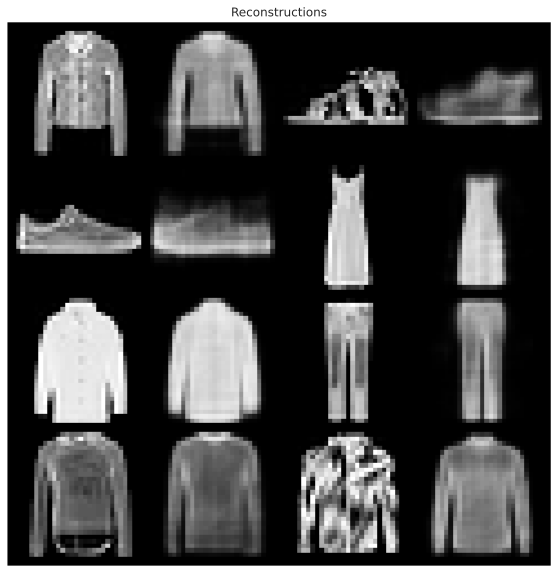

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [ ]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

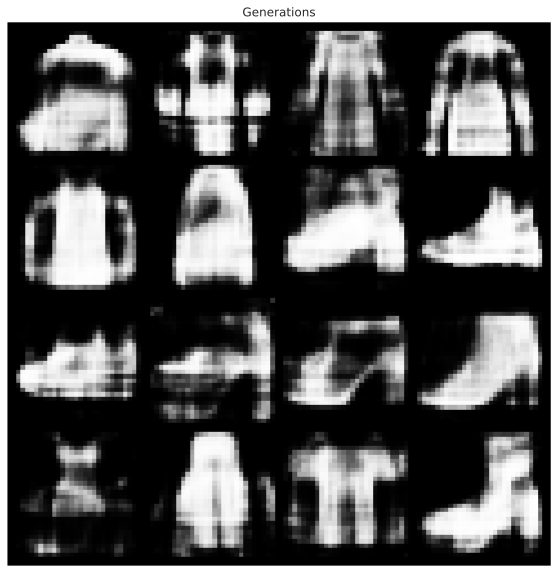

In [ ]:
generate_images(vae, 16 , device)

## Co poszło nie tak?

In [ ]:
import copy
vae_32 = copy.deepcopy(vae)

In [ ]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=784).to(device)

In [ ]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

 

    return reproduction_loss + KLD

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 6170.129884899172, test L1 = 0.07612744718790054
Epoch 1 loss 4483.334103315305, test L1 = 0.07372786868363619
Epoch 2 loss 4326.618625217014, test L1 = 0.07231040019541979
Epoch 3 loss 4244.384649814703, test L1 = 0.07124613299965858
Epoch 4 loss 4177.954908061231, test L1 = 0.06995084807276726
Epoch 5 loss 4128.939289321247, test L1 = 0.0693075129762292
Epoch 6 loss 4085.117898011819, test L1 = 0.0692277291789651
Epoch 7 loss 4049.675524589343, test L1 = 0.07009846493601798
Epoch 8 loss 4023.456280048077, test L1 = 0.06797343846410513
Epoch 9 loss 3999.1661783854165, test L1 = 0.06791024431586265
Epoch 10 loss 3969.6203268980366, test L1 = 0.06769531778991222
Epoch 11 loss 3952.4980020115518, test L1 = 0.06780087184160948
Epoch 12 loss 3938.656047592815, test L1 = 0.0673090297728777
Epoch 13 loss 3917.0135675413994, test L1 = 0.06731034480035306
Epoch 14 loss 3901.3699335603633, test L1 = 0.06667188853025437
Epoch 15 loss 3882.8297995542866, test L1 = 0.06675244402140379

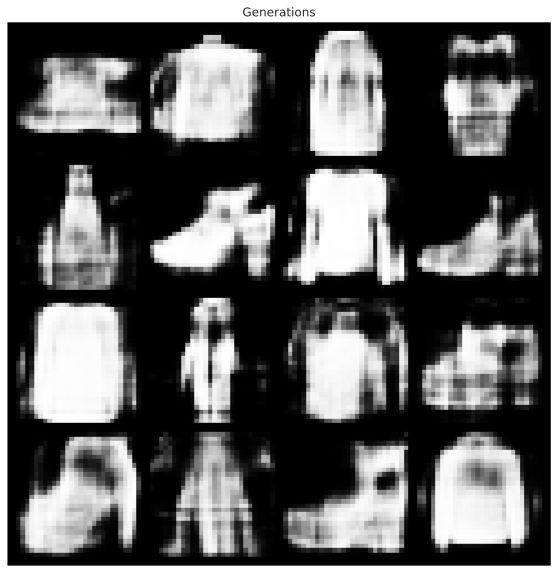

In [ ]:
generate_images(vae, 16 , device)

# Przestrzeń ukryta VAE

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))


In [ ]:
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

ModuleNotFoundError: ignored

In [ ]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

NameError: ignored

In [ ]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

In [ ]:
plot_latent(train_embedded, train_img_embeds)

In [ ]:
vae = VAE(latent_dim=2, hidden_dim=256, x_dim=784).to(device)

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
generate_images(vae, 16 , device)

In [ ]:
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = train_img_embeds[1][:5000].cpu()

In [ ]:
plot_latent(train_embedded, train_img_embeds)

In [ ]:
data = pd.DataFrame(train_embedded[:5000])
data["label"] = train_img_embeds[2][:5000].cpu().numpy()
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

# Generative Adversarial Networks

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat

In [ ]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=784).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [ ]:
fixed_noise = torch.randn(16, latent_dim,device=device)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0, discrimiantor fake error: 0.0651, discriminator real acc: 0.826


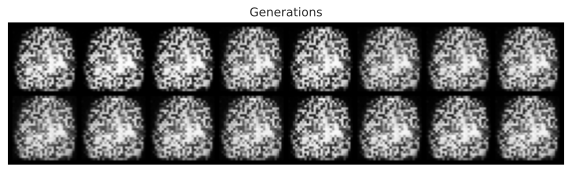

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1, discrimiantor fake error: 0.0317, discriminator real acc: 0.939
Epoch: 2, discrimiantor fake error: 0.0218, discriminator real acc: 0.958
Epoch: 3, discrimiantor fake error: 0.00675, discriminator real acc: 0.979
Epoch: 4, discrimiantor fake error: 0.00306, discriminator real acc: 0.99
Epoch: 5, discrimiantor fake error: 0.00129, discriminator real acc: 0.995
Epoch: 6, discrimiantor fake error: 0.00136, discriminator real acc: 0.997
Epoch: 7, discrimiantor fake error: 0.00143, discriminator real acc: 0.998
Epoch: 8, discrimiantor fake error: 0.00256, discriminator real acc: 0.997
Epoch: 9, discrimiantor fake error: 0.00979, discriminator real acc: 0.993
Epoch: 10, discrimiantor fake error: 0.0267, discriminator real acc: 0.978


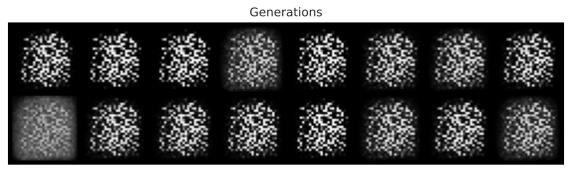

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 11, discrimiantor fake error: 0.02, discriminator real acc: 0.974
Epoch: 12, discrimiantor fake error: 0.0112, discriminator real acc: 0.985
Epoch: 13, discrimiantor fake error: 0.00639, discriminator real acc: 0.991
Epoch: 14, discrimiantor fake error: 0.00997, discriminator real acc: 0.991
Epoch: 15, discrimiantor fake error: 0.0592, discriminator real acc: 0.959
Epoch: 16, discrimiantor fake error: 0.0448, discriminator real acc: 0.95
Epoch: 17, discrimiantor fake error: 0.0244, discriminator real acc: 0.97
Epoch: 18, discrimiantor fake error: 0.0186, discriminator real acc: 0.978
Epoch: 19, discrimiantor fake error: 0.0435, discriminator real acc: 0.965
Epoch: 20, discrimiantor fake error: 0.06, discriminator real acc: 0.949


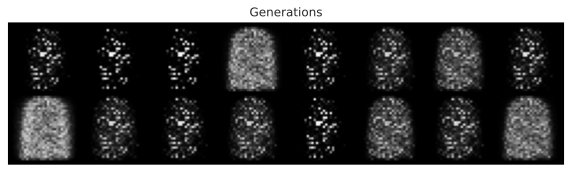

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 21, discrimiantor fake error: 0.0341, discriminator real acc: 0.958
Epoch: 22, discrimiantor fake error: 0.0304, discriminator real acc: 0.961
Epoch: 23, discrimiantor fake error: 0.0365, discriminator real acc: 0.962
Epoch: 24, discrimiantor fake error: 0.0508, discriminator real acc: 0.951
Epoch: 25, discrimiantor fake error: 0.0511, discriminator real acc: 0.948
Epoch: 26, discrimiantor fake error: 0.0418, discriminator real acc: 0.956
Epoch: 27, discrimiantor fake error: 0.0479, discriminator real acc: 0.953
Epoch: 28, discrimiantor fake error: 0.0588, discriminator real acc: 0.942
Epoch: 29, discrimiantor fake error: 0.0561, discriminator real acc: 0.946
Epoch: 30, discrimiantor fake error: 0.048, discriminator real acc: 0.951


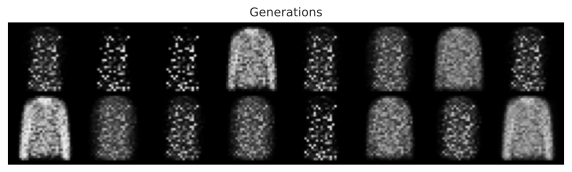

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 31, discrimiantor fake error: 0.0472, discriminator real acc: 0.952
Epoch: 32, discrimiantor fake error: 0.041, discriminator real acc: 0.959
Epoch: 33, discrimiantor fake error: 0.0457, discriminator real acc: 0.958
Epoch: 34, discrimiantor fake error: 0.0471, discriminator real acc: 0.953
Epoch: 35, discrimiantor fake error: 0.0464, discriminator real acc: 0.951
Epoch: 36, discrimiantor fake error: 0.0582, discriminator real acc: 0.943
Epoch: 37, discrimiantor fake error: 0.0705, discriminator real acc: 0.935
Epoch: 38, discrimiantor fake error: 0.0623, discriminator real acc: 0.936
Epoch: 39, discrimiantor fake error: 0.0732, discriminator real acc: 0.936
Epoch: 40, discrimiantor fake error: 0.0831, discriminator real acc: 0.919


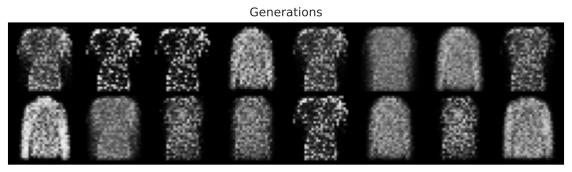

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 41, discrimiantor fake error: 0.0695, discriminator real acc: 0.933
Epoch: 42, discrimiantor fake error: 0.0776, discriminator real acc: 0.925
Epoch: 43, discrimiantor fake error: 0.0664, discriminator real acc: 0.934
Epoch: 44, discrimiantor fake error: 0.0692, discriminator real acc: 0.933
Epoch: 45, discrimiantor fake error: 0.0737, discriminator real acc: 0.928
Epoch: 46, discrimiantor fake error: 0.085, discriminator real acc: 0.925
Epoch: 47, discrimiantor fake error: 0.0754, discriminator real acc: 0.926
Epoch: 48, discrimiantor fake error: 0.0835, discriminator real acc: 0.923
Epoch: 49, discrimiantor fake error: 0.086, discriminator real acc: 0.921
Epoch: 50, discrimiantor fake error: 0.0851, discriminator real acc: 0.913


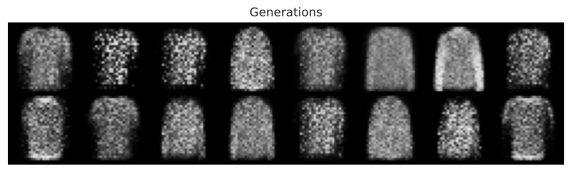

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 51, discrimiantor fake error: 0.0789, discriminator real acc: 0.923
Epoch: 52, discrimiantor fake error: 0.0754, discriminator real acc: 0.929
Epoch: 53, discrimiantor fake error: 0.0751, discriminator real acc: 0.925
Epoch: 54, discrimiantor fake error: 0.0718, discriminator real acc: 0.932
Epoch: 55, discrimiantor fake error: 0.0761, discriminator real acc: 0.926
Epoch: 56, discrimiantor fake error: 0.0761, discriminator real acc: 0.925
Epoch: 57, discrimiantor fake error: 0.0804, discriminator real acc: 0.922
Epoch: 58, discrimiantor fake error: 0.088, discriminator real acc: 0.913
Epoch: 59, discrimiantor fake error: 0.088, discriminator real acc: 0.918
Epoch: 60, discrimiantor fake error: 0.0803, discriminator real acc: 0.917


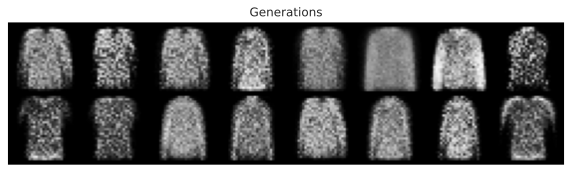

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 61, discrimiantor fake error: 0.0906, discriminator real acc: 0.907
Epoch: 62, discrimiantor fake error: 0.098, discriminator real acc: 0.909
Epoch: 63, discrimiantor fake error: 0.0958, discriminator real acc: 0.906
Epoch: 64, discrimiantor fake error: 0.0989, discriminator real acc: 0.909
Epoch: 65, discrimiantor fake error: 0.094, discriminator real acc: 0.904
Epoch: 66, discrimiantor fake error: 0.0965, discriminator real acc: 0.902
Epoch: 67, discrimiantor fake error: 0.103, discriminator real acc: 0.903
Epoch: 68, discrimiantor fake error: 0.105, discriminator real acc: 0.901
Epoch: 69, discrimiantor fake error: 0.096, discriminator real acc: 0.906
Epoch: 70, discrimiantor fake error: 0.0981, discriminator real acc: 0.905


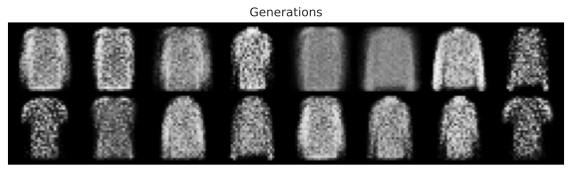

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 71, discrimiantor fake error: 0.105, discriminator real acc: 0.898
Epoch: 72, discrimiantor fake error: 0.107, discriminator real acc: 0.899
Epoch: 73, discrimiantor fake error: 0.11, discriminator real acc: 0.894
Epoch: 74, discrimiantor fake error: 0.112, discriminator real acc: 0.892
Epoch: 75, discrimiantor fake error: 0.108, discriminator real acc: 0.895
Epoch: 76, discrimiantor fake error: 0.105, discriminator real acc: 0.896
Epoch: 77, discrimiantor fake error: 0.112, discriminator real acc: 0.893
Epoch: 78, discrimiantor fake error: 0.108, discriminator real acc: 0.894
Epoch: 79, discrimiantor fake error: 0.11, discriminator real acc: 0.889
Epoch: 80, discrimiantor fake error: 0.108, discriminator real acc: 0.894


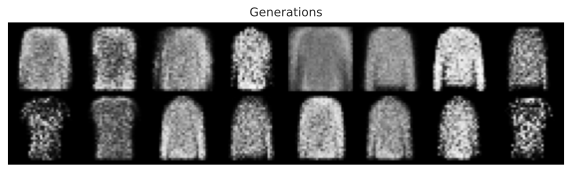

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 81, discrimiantor fake error: 0.116, discriminator real acc: 0.886
Epoch: 82, discrimiantor fake error: 0.11, discriminator real acc: 0.889
Epoch: 83, discrimiantor fake error: 0.122, discriminator real acc: 0.877
Epoch: 84, discrimiantor fake error: 0.126, discriminator real acc: 0.871
Epoch: 85, discrimiantor fake error: 0.119, discriminator real acc: 0.878
Epoch: 86, discrimiantor fake error: 0.137, discriminator real acc: 0.861
Epoch: 87, discrimiantor fake error: 0.129, discriminator real acc: 0.87
Epoch: 88, discrimiantor fake error: 0.123, discriminator real acc: 0.874
Epoch: 89, discrimiantor fake error: 0.135, discriminator real acc: 0.869
Epoch: 90, discrimiantor fake error: 0.14, discriminator real acc: 0.865


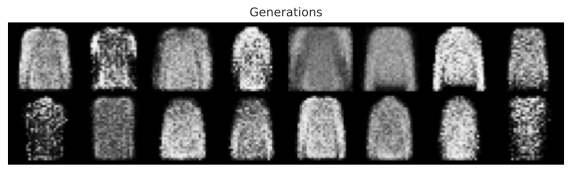

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 91, discrimiantor fake error: 0.13, discriminator real acc: 0.866
Epoch: 92, discrimiantor fake error: 0.126, discriminator real acc: 0.875
Epoch: 93, discrimiantor fake error: 0.132, discriminator real acc: 0.874
Epoch: 94, discrimiantor fake error: 0.14, discriminator real acc: 0.865
Epoch: 95, discrimiantor fake error: 0.142, discriminator real acc: 0.857
Epoch: 96, discrimiantor fake error: 0.143, discriminator real acc: 0.857
Epoch: 97, discrimiantor fake error: 0.138, discriminator real acc: 0.862
Epoch: 98, discrimiantor fake error: 0.147, discriminator real acc: 0.854
Epoch: 99, discrimiantor fake error: 0.136, discriminator real acc: 0.86


In [ ]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        # Calculate gradients for D in backward pass
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

## Stwórzmy model warunkowany klasą
Może się przydać F.one_hot

# Ewaluacja modeli generatywnych

In [ ]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(28*28, 256).to(device)

In [ ]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 7
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(test_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")

In [ ]:
vae = vae_32

In [ ]:
with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim,device=device)
    fixed_labels = torch.randint(10,(1000,),device=device)
    fixed_labels = F.one_hot(fixed_labels, 10).float()
    generations_cond_gan = cond_generator(fixed_noise, fixed_labels)
    generations_gan = generator(fixed_noise)
    generations_vae = vae.decoder(fixed_noise)

In [ ]:
orig_data = [x[0] for x in list(test_set)[:1000]]
orig_data = torch.cat(orig_data)

In [ ]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()
    dist_cond_gan = evaluator.get_features(generations_cond_gan.to(device)).cpu()

In [ ]:
for idx in range(5):
    bins = 10
    w = 0.3
    plt.figure(figsize=(10,10))
    plt.hist([dist_orig_data[:,idx].numpy(),dist_vae[:,idx].numpy(),dist_gan[:,idx], dist_cond_gan[:,idx]], bins, alpha=0.5, label=['orig','vae','gan','cond_gan'],width=w)
    plt.legend(loc='upper right')
    plt.show();
    plt.close()

In [ ]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
orig_data_2 = [x[0] for x in list(test_set)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [ ]:
for name, obj in zip(['orig','vae','gan','cond_gan'],[dist_orig_data_2.numpy(),dist_vae.numpy(),dist_gan.numpy(), dist_cond_gan.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")